In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from rivnet import (get_dx_dy,
                    get_distance_along_river_using_fmm,
                    get_distance_segments,
                    get_undirected_river_network,
                    direct_river_network_using_distance,
                    export_edges_to_geodataframe,
                    export_nodes_to_geodataframe,
                    get_latlon_centroid,
                    add_distance_to_ocean
                    )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd

# Initialize Paths for Data And Output

In [2]:
data_path = Path('data')
out_path = Path('out')

# Read Data

In [3]:
with rasterio.open(out_path/'water_mask.tif') as ds:
    water_mask = ds.read(1)

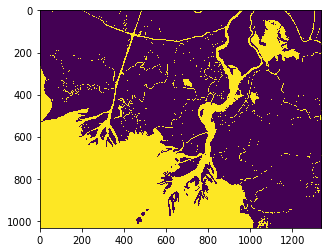

In [4]:
plt.imshow(water_mask)

In [5]:
with rasterio.open(out_path/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

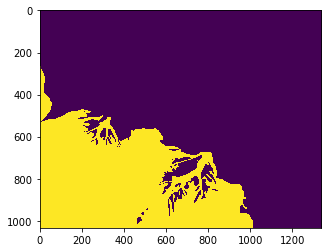

In [6]:
plt.imshow(ocean_mask)

We are going to get the resolution distance in the upper right corner (origin). Of course, this is not valid through the entire raster. The fast-marching method will use this `dx, dy` to approximate distance to our initialization mask (namely the ocean). We will update this distance at the end.

In [7]:
dx, dy = get_dx_dy(profile)
dx, dy

(33.228043103102486, 33.074815716440916)

In [8]:
dist = get_distance_along_river_using_fmm(water_mask,
                                          ocean_mask,
                                          dx=dx,
                                          dy=dy,
                                          )

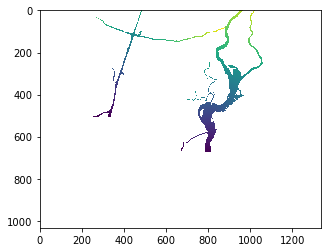

In [9]:
plt.imshow(dist)

We write the distance raster.

In [10]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(out_path/'distance.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

We threshold the distance according to some number of pixels - below we use `pixel_step`.

In [11]:
pixel_step = 10

segments = get_distance_segments(dist,
                                 pixel_step,
                                 dx=dx,
                                 dy=dy)

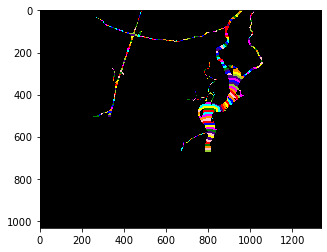

In [12]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb)

In [13]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(out_path/'segments.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

# Making an Undirected Network

In [14]:
rivG_undirected = get_undirected_river_network(segments, dist, profile)

In [15]:
type(rivG_undirected)

networkx.classes.graph.Graph

In [16]:
node_data =dict(rivG_undirected.nodes(data=True))
random.choice(list(node_data.items()))

((-91.2715252345527, 29.495606285667844),
 {'label': 351,
  'meters_to_coast': 1637.203369140625,
  'lon': -91.2715252345527,
  'lat': 29.495606285667844})

In [17]:
edge_data =(rivG_undirected.edges(data=True))
edge_data = {(e[0], e[1]): e[2] for e in edge_data}
random.choice(list(edge_data.items()))

(((-91.29154541947564, 29.566211132774797),
  (-91.29092823318678, 29.56336083315686)),
 {'length_m': 321.5529082351966, 'weight': 321.5529082351966})

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


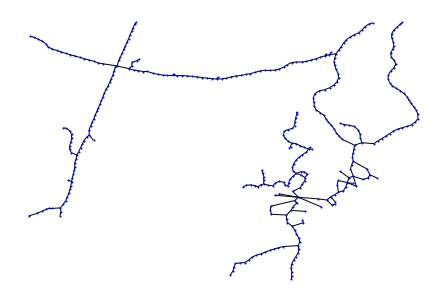

In [18]:
pos = {node: node for node in node_data.keys()}
nx.draw(rivG_undirected, 
        pos=pos, 
        node_size=1, 
        node_color='blue')
plt.show()

# A First Pass At A Directed Network

In [19]:
rivG = direct_river_network_using_distance(rivG_undirected, remove_danlging_segments=True)

1it [00:00, 135.69it/s]
1it [00:00, 129.13it/s]


/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


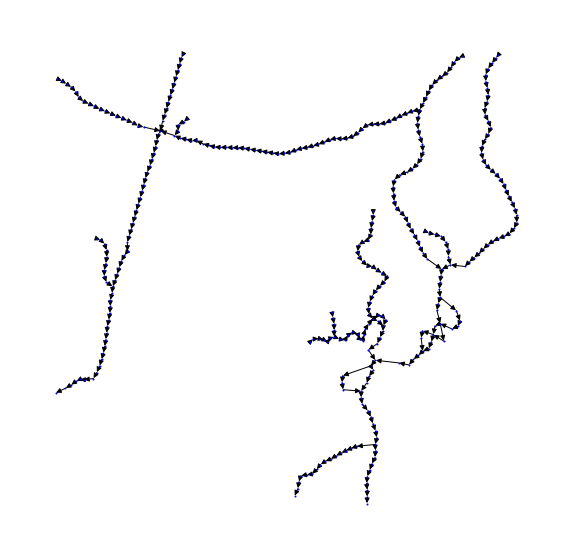

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(rivG, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

In [21]:
df_edges = export_edges_to_geodataframe(rivG)
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,312.797342,312.797342,0,9,0,LINESTRING (-91.26692624690834 29.509869894953...
1,1052.911203,1052.911203,2,15,0,LINESTRING (-91.26692624690834 29.509869894953...
2,332.017154,332.017154,0,9,0,LINESTRING (-91.26672589591369 29.507053387086...
3,353.103038,353.103038,0,9,0,LINESTRING (-91.26705193598463 29.504071644793...
4,336.564179,336.564179,0,9,0,LINESTRING (-91.26879862215242 29.501276420671...


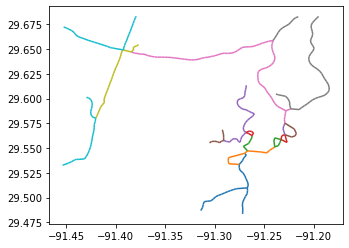

In [22]:
df_edges.plot(column='segment_id', categorical=True)

# Updating Distances and Redirecting Network

We are going to add a node in the middle of the ocean that will act as a sink.

In [23]:
ocean_centroid = get_latlon_centroid(ocean_mask, profile)
ocean_centroid

(-91.40764383603118, 29.442612997045195)

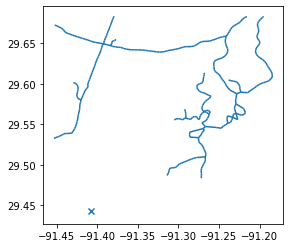

In [24]:
fig, ax = plt.subplots()
df_ocean_centroid = gpd.GeoDataFrame(geometry=[Point(ocean_centroid)],
                                     crs={'init':'epsg:4326'})
df_edges.plot(ax=ax)
df_ocean_centroid.plot(ax=ax, marker='x')

In [25]:
rivG, rivG_aux = add_distance_to_ocean(rivG, ocean_centroid, use_directed=False)

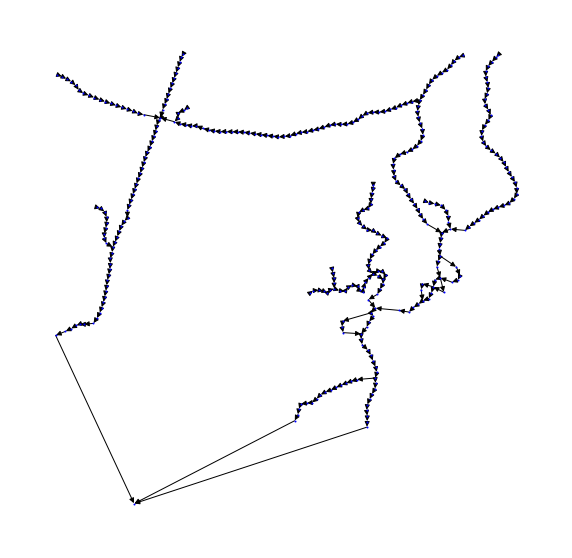

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
pos[ocean_centroid] = ocean_centroid

nx.draw(rivG_aux, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

In [27]:
rivG = direct_river_network_using_distance(rivG.to_undirected(), remove_danlging_segments=False)

1it [00:00, 137.66it/s]


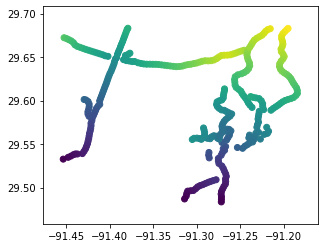

In [28]:
df_nodes = export_nodes_to_geodataframe(rivG)
df_nodes.plot(column='meters_to_coast')

# Save Network

For shapefiles - remove the driver keyword.

In [ ]:
df_edges.to_file(out_path/'rivnet_edges.geojson', driver='GeoJSON')
df_nodes.to_file(out_path/'rivnet_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(rivG, out_path/'river_network.pkl')